# Qdrant Collection Creation

## Prerequisites

In [1]:
import random
from pprint import pprint
import time

from qdrant_client import QdrantClient
from qdrant_client.http.models import PayloadSchemaType
from qdrant_client.models import (
    Distance,
    VectorParams,
    OptimizersConfig,
    ScalarQuantizationConfig,
    ScalarType,
    ScalarQuantization,
    OptimizersConfigDiff,
    HnswConfigDiff,
    PointStruct,
    Filter,
    FieldCondition,
    MatchValue,
    Nested,
    NestedCondition,
    MatchAny,
    LookupLocation,
)
from sklearn.datasets import make_blobs
from ray.util.multiprocessing import Pool

## Global Variables

In [2]:
QDRANT_HOST = 'localhost'
QDRANT_PORT = 6333
QDRANT_GRPC_PORT = 6334

CLIENT = QdrantClient(
    url=QDRANT_HOST, 
    port=QDRANT_PORT, 
    grpc_port=QDRANT_GRPC_PORT,
    prefer_grpc=True
)

CUSTOMER_COLLECTION_NAME = 'customer_collection'
PRODUCT_COLLECTION_NAME = 'product_collection'

NUMBER_OF_FEATURES = 192
NUMBER_OF_POINTS = 150_000
NUMBER_OF_CENTERS = 25

CATEGORIES = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', ]
ASSORTMENT = [
    ['a1', 'a3'],
    ['a3'],
    ['a1', 'a2'],
    ['a4'],
    ['a2', 'a7'],
    ['a2'],
    ['a4', 'a2'],
]

## Functions

In [3]:
def get_collection_info(collection_name: str):
    collection_info = CLIENT.get_collection(collection_name)
    info = f"""
name: {collection_name} status: {collection_info.status.value}
=======================================================================
points count: {collection_info.points_count}
vector count: {collection_info.vectors_count}
indexed vectors count: {collection_info.indexed_vectors_count}

collection info: {collection_info}
"""
    print(info)


def create_vectors(n: int = NUMBER_OF_POINTS) -> list:
    vectors, _ = make_blobs(n_samples=n,
                            n_features=NUMBER_OF_FEATURES,
                            centers=NUMBER_OF_CENTERS,
                            cluster_std=2.0,
                            center_box=(-5, 5),
                            shuffle=True,
                            random_state=1)
    return [v.tolist() for v in vectors]


def create_points(n: int = NUMBER_OF_POINTS) -> list:
    vectors = create_vectors(n)
    points = []
    for i, vector in enumerate(vectors):
        point = {
            'id': i+1,
            'vector': vector,
            'payload': {
                'category': CATEGORIES[random.randint(0, len(CATEGORIES)-1)],
                'stores': [
                    {'id': j, 'assortment': ASSORTMENT[random.randint(0, len(ASSORTMENT)-1)]}
                for j in range(0, 25)],
            }
        }
        points.append(point)
    return points


def upsert_points(chunk: dict):
    collection_name = chunk['collection_name']
    points = chunk['chunk']
    
    client = QdrantClient(host=QDRANT_HOST,
                          port=QDRANT_PORT,
                          # grpc_port=QDRANT_GRPC_PORT,
                          # prefer_grpc=True,
                          timeout=100_000)
    client.upsert(
        collection_name=collection_name, 
        points=[PointStruct(id=p['id'], 
                        vector=p['vector'], 
                        payload=p['payload']) for p in points]
    )


def chunks(l: list, n: int, collection_name):
    for i in range(0, len(l), n):
        yield {'collection_name': collection_name, 'chunk': l[i:i+n]}


VECTOR_PARAMS = VectorParams(size=NUMBER_OF_FEATURES, distance=Distance.COSINE)
QUANTIZATION_CONFIG = ScalarQuantization(scalar=ScalarQuantizationConfig(type=ScalarType.INT8, always_ram=True))
OPTIMIZERS_CONFIG = OptimizersConfigDiff(memmap_threshold=20_000, indexing_threshold=1)
HNSW_CONFIG = HnswConfigDiff(m=16, ef_construct=100, full_scan_threshold=10_000)


def create_index(collection_name: str):
    field = 'category'
    CLIENT.create_payload_index(collection_name, field, PayloadSchemaType.KEYWORD)
    # while CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points != NUMBER_OF_POINTS:
    #     print(f"Zzzz... Waiting for index on {field} to be created. ({CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points}/{NUMBER_OF_POINTS}).")
    #     time.sleep(5)

    field = 'stores[].id'
    CLIENT.create_payload_index(collection_name, field, PayloadSchemaType.INTEGER)
    # while CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points != NUMBER_OF_POINTS:
    #     print(f"Zzzz... Waiting for index on {field} to be created. ({CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points}/{NUMBER_OF_POINTS}).")
    #     time.sleep(5)

    field = 'stores[].assortment'
    CLIENT.create_payload_index(collection_name, field, PayloadSchemaType.KEYWORD)
    # while CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points != NUMBER_OF_POINTS:
    #     print(f"Zzzz... Waiting for index on {field} to be created. ({CLIENT.get_collection(COLLECTION_NAME).payload_schema[field].points}/{NUMBER_OF_POINTS}).")
    #     time.sleep(5)

                             
def create_collection(collection_name: str, points: list):
    CLIENT.recreate_collection(collection_name=collection_name,
                               vectors_config=VECTOR_PARAMS,
                               shard_number=1,
                               on_disk_payload=False,
                               optimizers_config=OPTIMIZERS_CONFIG,
                               quantization_config=QUANTIZATION_CONFIG)
    create_index(collection_name)
    
    pool = Pool()
    pool.map(upsert_points, chunks(points, 2_000, collection_name))
    pool.close()
    pool.join()
    # for chunk in chunks(points, 2_000):
    #     upsert_points(chunk)


def recommend(recommend_collection_name: str, 
              lookup_collection_name: str, 
              lookup_ids: list, 
              filter=None) -> float:
    durations = []
    for lookup_id in lookup_ids:
        start_time = time.time()
        hits = CLIENT.recommend(recommend_collection_name,
                                positive=[lookup_id],
                                lookup_from=LookupLocation(collection=lookup_collection_name),
                                limit=5,
                                query_filter=filter)
        durations.append(time.time() - start_time)
    return sum(durations) / len(durations)


def get_top_level_filter() -> Filter:
    return Filter(must=[FieldCondition(key='category', match=MatchValue(value='c3'))])


def get_nested_filter() -> Filter:
    return Filter(
        must=[
            NestedCondition(
                nested=Nested(
                    key='stores', 
                    filter=Filter(
                        must=[
                            FieldCondition(key='id', match=MatchValue(value=4)),
                            FieldCondition(key='assortment', match=MatchAny(any=['a1'])),
                        ]
                    )
                )
            )
        ]
    )

# Big Experiment

In [4]:
import matplotlib.pyplot as plt


def plot_duration_measurement(duration_measurement: list):
    x = [r['number_of_points'] for r in results]
    y_wo_filter = [r['duration_wo_filter'] for r in results]
    y_top_level_filter = [r['duration_top_level_filter'] for r in results]
    y_nested_filter = [r['duration_nested_filter'] for r in results]
    
    plt.plot(x, y_wo_filter, label='w/o filter')
    plt.plot(x, y_top_level_filter, label='top level filter')
    plt.plot(x, y_nested_filter, label='nested filter')
    
    plt.xlabel("Number of Points")
    plt.ylabel("Duration in Seconds")
    plt.title('Duration Search')
    plt.show()

In [5]:
results = []

for number_of_points in range(10_000, 150_000, 10_000):
    print(f"Processing {number_of_points} points")
    all_points = create_points(n=number_of_points)
    random.shuffle(all_points)
    
    split_at = int(number_of_points/10)
    customer_points = all_points[:split_at]
    product_points = all_points[split_at:]
    
    create_collection(CUSTOMER_COLLECTION_NAME, customer_points)
    create_collection(PRODUCT_COLLECTION_NAME, product_points)

    while CLIENT.get_collection(CUSTOMER_COLLECTION_NAME).status.value == 'yellow':
        time.sleep(15)
        print(f"Still waiting for {CUSTOMER_COLLECTION_NAME} to be indexed. {CLIENT.get_collection(CUSTOMER_COLLECTION_NAME).indexed_vectors_count}/{len(customer_points)}")

    while CLIENT.get_collection(PRODUCT_COLLECTION_NAME).status.value == 'yellow':
        time.sleep(15)
        print(f"Still waiting for {PRODUCT_COLLECTION_NAME} to be indexed. {CLIENT.get_collection(PRODUCT_COLLECTION_NAME).indexed_vectors_count}/{len(product_points)}")

    lookup_ids = [c['id'] for c in customer_points[:50]]
    duration_wo_filter = recommend(recommend_collection_name=PRODUCT_COLLECTION_NAME,
                                   lookup_ids=lookup_ids,
                                   lookup_collection_name=CUSTOMER_COLLECTION_NAME)
    
    duration_top_level_filter = recommend(recommend_collection_name=PRODUCT_COLLECTION_NAME,
                                          lookup_ids=lookup_ids,
                                          lookup_collection_name=CUSTOMER_COLLECTION_NAME,
                                          filter=get_top_level_filter())
    
    duration_nested_filter = recommend(recommend_collection_name=PRODUCT_COLLECTION_NAME,
                                       lookup_ids=lookup_ids,
                                       lookup_collection_name=CUSTOMER_COLLECTION_NAME,
                                       filter=get_nested_filter())

    results.append({
        'number_of_points': number_of_points,
        'duration_wo_filter': duration_wo_filter,
        'duration_top_level_filter': duration_top_level_filter,
        'duration_nested_filter': duration_nested_filter,
    })

Processing 10000 points


2023-07-18 16:50:36,700	INFO worker.py:1636 -- Started a local Ray instance.


Processing 20000 points
Processing 30000 points
Still waiting for product_collection to be indexed. 21000/30000
Still waiting for product_collection to be indexed. 27000/30000
Processing 40000 points
Still waiting for product_collection to be indexed. 14000/40000
Still waiting for product_collection to be indexed. 36000/40000
Processing 50000 points
Still waiting for product_collection to be indexed. 19000/50000
Still waiting for product_collection to be indexed. 45000/50000
Processing 60000 points
Still waiting for product_collection to be indexed. 24000/60000
Processing 70000 points
Still waiting for product_collection to be indexed. 0/70000
Still waiting for product_collection to be indexed. 25000/70000
Still waiting for product_collection to be indexed. 63000/70000
Processing 80000 points
Still waiting for product_collection to be indexed. 0/80000
Still waiting for product_collection to be indexed. 30000/80000
Still waiting for product_collection to be indexed. 56000/80000
Still wa

In [6]:
results

[{'number_of_points': 10000,
  'duration_wo_filter': 0.003467965126037598,
  'duration_top_level_filter': 0.002760176658630371,
  'duration_nested_filter': 0.016370120048522948},
 {'number_of_points': 20000,
  'duration_wo_filter': 0.004938797950744629,
  'duration_top_level_filter': 0.0029241132736206057,
  'duration_nested_filter': 0.0258123254776001},
 {'number_of_points': 30000,
  'duration_wo_filter': 0.005326905250549316,
  'duration_top_level_filter': 0.0033956718444824218,
  'duration_nested_filter': 0.044957947731018064},
 {'number_of_points': 40000,
  'duration_wo_filter': 0.004805669784545898,
  'duration_top_level_filter': 0.0029224729537963867,
  'duration_nested_filter': 0.02978097915649414},
 {'number_of_points': 50000,
  'duration_wo_filter': 0.005080738067626953,
  'duration_top_level_filter': 0.003923153877258301,
  'duration_nested_filter': 0.02967306613922119},
 {'number_of_points': 60000,
  'duration_wo_filter': 0.007105402946472168,
  'duration_top_level_filter': 

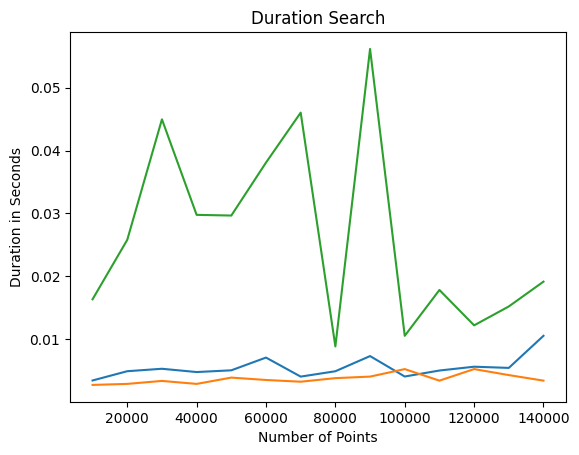

In [7]:
plot_duration_measurement(results)

In [9]:
get_collection_info(CUSTOMER_COLLECTION_NAME)
get_collection_info(PRODUCT_COLLECTION_NAME)


name: customer_collection status: green
points count: 14000
vector count: 14000
indexed vectors count: 14000

collection info: status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=14000 indexed_vectors_count=14000 points_count=14000 segments_count=3 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=192, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=False), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=20000, indexing_threshold=1, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), qua